## Front-Door Criterion
**Hands‑on Notebook**


**In this notebook**
- Understand when back-door fails (unobserved confounder).
- Apply the front-door conditions.
- Compute the front-door formula step by step.

### 1. Theory: Front-door criterion
We sometimes cannot adjust for the confounder because it is **unobserved** (e.g. genetic predisposition).
If there is a mediator $Z$ such that:
1. $Z$ intercepts all directed paths from $X$ to $Y$,
2. there is no unblocked back-door path from $X$ to $Z$, and
3. all back-door paths from $Z$ to $Y$ are blocked by $X$,
then we can identify the causal effect using the **front-door adjustment**:

$$P(y \mid do(x)) = \sum_z P(z \mid x) \sum_{x'} P(y \mid x', z) P(x').$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(123)

![Backdoor Simple Graph](../images/frontdoorwithU.png)

In [3]:
# simulate smoking (X), tar (Z), cancer (Y) with unobserved U
N = 60_000
U = np.random.binomial(1, 0.5, size=N)  # unobserved risk factor

# X depends on U
p_x = np.where(U == 1, 0.8, 0.2)
X = np.random.binomial(1, p_x)

# Z (tar) depends on X only (condition 2 of front-door)
p_z = np.where(X == 1, 0.9, 0.1)
Z = np.random.binomial(1, p_z)

# Y depends on Z and U (so U is a confounder we cannot adjust for directly)
Z_EFFECT = 0.25  # Effect of Z (tar) on Y (cancer)
Y_prob = 0.05 + Z_EFFECT * Z + 0.25 * U
Y_prob = np.clip(Y_prob, 0, 1)
Y = np.random.binomial(1, Y_prob)

# True causal effect of X on Y (through Z)
# E[Z|do(X=1)] - E[Z|do(X=0)] = 0.9 - 0.1 = 0.8
# True effect = 0.8 * 0.25 = 0.2
TRUE_EFFECT = 0.8 * Z_EFFECT

df_fd = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y, 'U': U})
df_fd.head()

,X,Z,Y,U
0,0,0,1,1
1,0,0,0,0
2,0,0,0,0
3,1,1,1,1
4,1,1,1,1


### 2. Naive estimate (will be biased)
Because U affects both X and Y, the simple comparison of smokers vs non-smokers will not recover the true effect.

In [4]:
p_y_x1 = df_fd.loc[df_fd.X == 1, 'Y'].mean()
p_y_x0 = df_fd.loc[df_fd.X == 0, 'Y'].mean()
naive_effect = p_y_x1 - p_y_x0

print(f"Naive estimate: {naive_effect:.3f} (BIASED due to hidden confounder U)")
print(f"True effect:    {TRUE_EFFECT:.3f} (causal effect through mediator Z)")
naive_effect

Naive estimate: 0.350 (BIASED due to hidden confounder U)
True effect:    0.200 (causal effect through mediator Z)


np.float64(0.3499369260927919)

### 3. Front-door estimation step by step
We implement
$$P(y \mid do(x)) = \sum_z P(z \mid x) \sum_{x'} P(y \mid x', z) P(x').$$

In [5]:
def front_door_effect(df, x_val=1):
    """
    Compute P(Y=1 | do(X=x_val)) using the front-door formula:
    P(y | do(x)) = ∑_z P(z|x) · ∑_{x'} P(y|x',z) · P(x')
    """
    
    # Step 1: Compute P(x') - the marginal distribution of X
    # This gives us the probability of each treatment value in the population
    p_xprime = df['X'].value_counts(normalize=True).sort_index()
    
    # Step 2: Compute P(z|x) - probability of mediator Z given treatment X
    # This captures how X affects Z (first stage of the causal chain)
    p_z_given_x = (
        df.groupby(['X', 'Z']).size()
        / df.groupby('X').size()
    ).unstack(fill_value=0)
    
    # Step 3: Compute P(y|x',z) - probability of outcome given treatment and mediator
    # This captures how Z affects Y, adjusting for confounding through X
    p_y_given_xz = (
        df.groupby(['X', 'Z'])['Y'].mean()
        .unstack(fill_value=0)
    )
    
    # Step 4: Implement the front-door formula with nested summations
    total = 0.0
    
    # Outer sum: over mediator values z
    for z_val in [0, 1]:
        # Get P(z|x) for this specific z value
        p_z_given_xval = p_z_given_x.loc[x_val, z_val]
        
        # Inner sum: ∑_{x'} P(y|x',z) · P(x')
        # This averages out the effect of the confounder U
        inner_sum = 0.0
        for xprime, pxp in p_xprime.items():
            # P(y|x',z) for this combination of x' and z
            py_xprime_z = p_y_given_xz.loc[xprime, z_val]
            # Weight by P(x')
            inner_sum += py_xprime_z * pxp
        
        # Multiply by P(z|x) and add to total
        total += p_z_given_xval * inner_sum
    
    return total

# Compute causal effect using front-door adjustment
p_y_do1 = front_door_effect(df_fd, x_val=1)  # P(Y=1 | do(X=1))
p_y_do0 = front_door_effect(df_fd, x_val=0)  # P(Y=1 | do(X=0))
fd_effect = p_y_do1 - p_y_do0  # Causal effect

print(f"Naive estimate:     {naive_effect:.3f} (BIASED)")
print(f"Front-door estimate: {fd_effect:.3f} (UNBIASED)")
print(f"True effect:        {TRUE_EFFECT:.3f} (set in data generation)")
#fd_effect

Naive estimate:     0.350 (BIASED)
Front-door estimate: 0.195 (UNBIASED)
True effect:        0.200 (set in data generation)


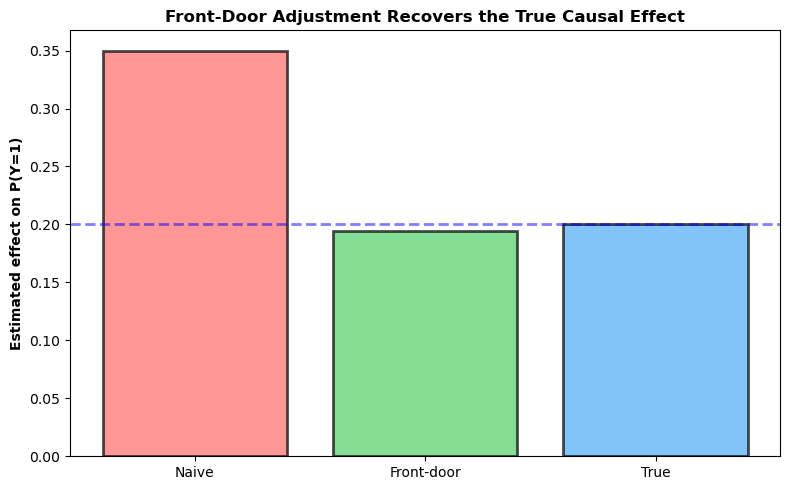

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(['Naive', 'Front-door', 'True'], [naive_effect, fd_effect, TRUE_EFFECT],
       color=['#ff6b6b', '#51cf66', '#4dabf7'], alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=TRUE_EFFECT, color='blue', linestyle='--', linewidth=2, alpha=0.5)
ax.set_ylabel('Estimated effect on P(Y=1)', fontweight='bold')
ax.set_title('Front-Door Adjustment Recovers the True Causal Effect', fontweight='bold')
plt.tight_layout()
plt.show()

### 4. Exercises
Change the strength of the hidden confounder U and discuss what happens.


Results (difference in probabilities: E[Y|X=1] - E[Y|X=0])



,naive,frontdoor,true,true_y1,true_y0
conf_strength,,,,,
0.0,0.234242,0.236815,0.235205,0.713440,0.478235
0.5,0.264363,0.227169,0.231100,0.709895,0.478795
1.0,0.336237,0.220772,0.218500,0.698730,0.480230
2.0,0.486475,0.184344,0.181200,0.666010,0.484810
4.0,0.675884,0.118382,0.125235,0.613600,0.488365


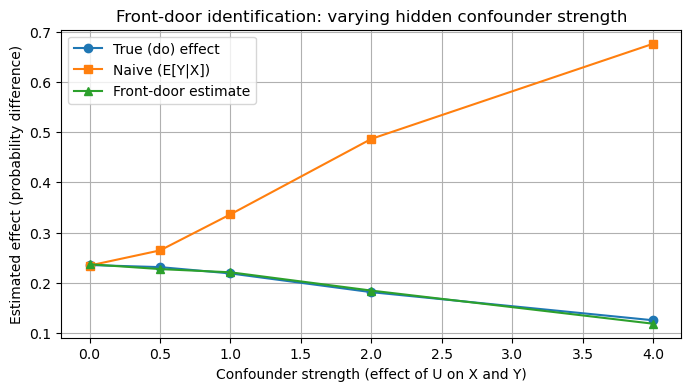

In [9]:

# Exercise 4 (Front-door): Vary confounder strength and compare Naive / Front-door / True effects
from scipy.special import expit  # logistic

np.random.seed(2025)

def simulate_frontdoor(N=200_000, conf_strength=1.0):
    """
    Data generating process for a front-door model:
      U ~ N(0,1)                (hidden confounder)
      X ~ Bernoulli(sigmoid(alpha * U + eps_x))   (confounded by U; alpha = conf_strength)
      M = beta_x * X + eps_m     (mediator, not influenced by U)
      Y_prob = sigmoid(gamma_m * M + gamma_u * U)   (Y depends on M and U)
      Y ~ Bernoulli(Y_prob)
    Front-door identification requires: U -> X, U -> Y, X -> M -> Y, and U does NOT affect M.
    """
    alpha = conf_strength   # strength of U -> X
    beta_x = 1.2            # X -> M
    sigma_x_noise = 1.0
    sigma_m_noise = 1.0
    gamma_m = 1.0           # M -> Y
    gamma_u = 0.8 * conf_strength  # U -> Y (scale with conf_strength so total confounding grows)
    
    # Simulate
    U = np.random.normal(0, 1, N)
    logits_x = alpha * U  # plus noise through Bernoulli randomness
    pX = expit(logits_x)
    X = np.random.binomial(1, pX)
    
    M = beta_x * X + np.random.normal(0, sigma_m_noise, N)  # M not affected by U
    logits_y = gamma_m * M + gamma_u * U - 0.1  # intercept included
    pY = expit(logits_y)
    Y = np.random.binomial(1, pY)
    
    df = pd.DataFrame(dict(U=U, X=X, M=M, Y=Y, pX=pX, pY=pY))
    return df

def frontdoor_estimator(df, x_val=1, m_bins=50):
    """
    Compute P(Y | do(X=x_val)) via discrete approximation of the front-door formula:
    P(Y | do(x)) = sum_m P(M=m | X=x) * sum_{x'} P(Y | X=x', M=m) P(X=x')
    We discretize M into bins and approximate integrals by sums.
    """
    # discretize M
    df2 = df.copy()
    df2['_m_bin'] = pd.qcut(df2['M'], q=m_bins, duplicates='drop')
    # P(X=x')
    p_x = df2['X'].mean()
    p_x_dict = {1: p_x, 0: 1 - p_x}
    
    # Compute P(M_bin | X=x)
    pm_given_x = {}
    for x in [0,1]:
        grp = df2[df2['X']==x]
        pm = grp['_m_bin'].value_counts(normalize=True).sort_index()
        pm_given_x[x] = pm  # Series indexed by interval bins
    
    # Compute P(Y | X=x', M_bin = m)
    py_given_xm = df2.groupby(['_m_bin','X'], observed=True)['Y'].mean().unstack()  # rows: bins, cols: X=0/1

    
    # For each bin, compute inner sum over x' of P(Y|x',m) P(x')
    # then multiply by P(M_bin | X=x_val) and sum over bins
    total = 0.0
    bins = py_given_xm.index
    for b in bins:
        p_m_given_x = pm_given_x[x_val].get(b, 0.0)  # P(M in bin b | X = x_val)
        # Handle missing bins by treating P(Y|x',m) as 0.0 if not observed (should be rare with large N)
        py_x0 = py_given_xm.loc[b].get(0, np.nan)
        py_x1 = py_given_xm.loc[b].get(1, np.nan)
        # If either is NaN (no observations), skip this bin (weight is zero)
        if np.isnan(py_x0) or np.isnan(py_x1):
            continue
        inner = py_x0 * p_x_dict[0] + py_x1 * p_x_dict[1]
        total += p_m_given_x * inner
    return total

def true_do_effect_by_simulation(conf_strength, N=200_000):
    """
    Compute E[Y | do(X=1)] and E[Y | do(X=0)] by simulating U from its marginal,
    then generating M according to the structural equation with X fixed, and Y using U and M.
    Returns difference E[Y|do(1)] - E[Y|do(0)].
    """
    alpha = conf_strength
    beta_x = 1.2
    sigma_m_noise = 1.0
    gamma_m = 1.0
    gamma_u = 0.8 * conf_strength
    
    U = np.random.normal(0, 1, N)
    # do(X=1)
    M1 = beta_x * 1 + np.random.normal(0, sigma_m_noise, N)
    pY1 = expit(gamma_m * M1 + gamma_u * U - 0.1)
    Y1 = np.random.binomial(1, pY1)
    # do(X=0)
    M0 = beta_x * 0 + np.random.normal(0, sigma_m_noise, N)
    pY0 = expit(gamma_m * M0 + gamma_u * U - 0.1)
    Y0 = np.random.binomial(1, pY0)
    return Y1.mean() - Y0.mean(), Y1.mean(), Y0.mean()

# Run experiment for several confounder strengths
conf_strengths = [0.0, 0.5, 1.0, 2.0, 4.0]
rows = []
for cs in conf_strengths:
    df = simulate_frontdoor(N=200_000, conf_strength=cs)
    # naive estimate
    naive = df.groupby('X')['Y'].mean().diff().iloc[-1]  # E[Y|X=1] - E[Y|X=0]
    # front-door estimates for do(1) and do(0)
    fd_do1 = frontdoor_estimator(df, x_val=1, m_bins=60)
    fd_do0 = frontdoor_estimator(df, x_val=0, m_bins=60)
    fd_effect = fd_do1 - fd_do0
    # true effect by simulation
    true_effect, true_y1, true_y0 = true_do_effect_by_simulation(cs, N=200_000)
    rows.append(dict(conf_strength=cs,
                     naive=naive,
                     frontdoor=fd_effect,
                     true=true_effect,
                     true_y1=true_y1,
                     true_y0=true_y0))
    
res = pd.DataFrame(rows)
res = res.set_index('conf_strength')
print("Results (difference in probabilities: E[Y|X=1] - E[Y|X=0])\n")
display(res)

# Plot results
plt.figure(figsize=(8,4))
plt.plot(res.index, res['true'], marker='o', label='True (do) effect')
plt.plot(res.index, res['naive'], marker='s', label='Naive (E[Y|X])')
plt.plot(res.index, res['frontdoor'], marker='^', label='Front-door estimate')
plt.xlabel("Confounder strength (effect of U on X and Y)")
plt.ylabel("Estimated effect (probability difference)")
plt.title("Front-door identification: varying hidden confounder strength")
plt.legend()
plt.grid(True)
plt.show()

## Explanation
When the confounder (U) is strong, the naive estimate of P(Y|X) is biased because X and Y are linked through U.  
As we weaken the confounder, this bias decreases, and the naive estimate gets closer to the true causal effect.  
The front-door adjusted estimate remains stable and accurate in all cases, since it correctly accounts for the mediation path X → M → Y even with unobserved confounding.